# MLP

The bigram model using probablities based on normalized counts has it's limitations.

To extend it to have more context like a two characters as input the probabalities matrix will have (27*27) possilities and for three characters (27 * 27 * 27) and becomes too big.

To overcome this we're gonna try out [Bengion et al.2003 MLP model paper](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbVhPSHNrVkluYVY5elh4RDZrOWd4R2xVNVRQd3xBQ3Jtc0tsUDE0UFVRQURUTTlWckExZWp4eGxFa3lRYlQ3amtYX3kxdDI1ZW5uU1pxZERidUYyZkJjSVlzd21rMndCMFlYRW5kYmZISkxfSDR1TzhaOXI1bXptUnUxU0xyUXJYeEpTZlRrTkRjTS0wTkMxNjFnSQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I)

* This paper uses words but we'll proceed with characters
* Each character will be represented as a 30 dimensional vector 
* The advantages of embeddings is knowledge transference, for examples animals like dog, cat might be closer to each other in 30 dimensional space. If cat was not in training set but this knowledge transfer will help in this case.

Let's implement the below architecture in this notebook
![fully connected MLP](https://pbs.twimg.com/media/Fhzl42hVUAI9U8V?format=jpg&name=large)

* Three input characters with 30 dimensional embedding each
* A Lookup table for characters
* Tanh activation connected to three inputs
* since we have 27 characters a final layer with 27 units(logits)
* softmax on top of it to normalize the probabality
* pluck the label based on probabality

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Rebuilding training dataset

In [2]:
# Read all words
def read_words():
    words = open("names.txt").read().splitlines()
    return words
words = read_words()

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi  = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the dataset

In [5]:
def build_dataset(block_size, number_of_words: int, logs=False):

    block_size = block_size # Context ength: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words[:number_of_words]:
        if logs:
            print(w)
        context = [0] * block_size
        for ch in w + '.':
            if logs:
                print(f"Context: {context}")
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if logs:
                print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
            if logs:
                print(f"Context after append: {context}")

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
X, Y = build_dataset(block_size=3, number_of_words=5, logs=True)

emma
Context: [0, 0, 0]
... ---> e
Context after append: [0, 0, 5]
Context: [0, 0, 5]
..e ---> m
Context after append: [0, 5, 13]
Context: [0, 5, 13]
.em ---> m
Context after append: [5, 13, 13]
Context: [5, 13, 13]
emm ---> a
Context after append: [13, 13, 1]
Context: [13, 13, 1]
mma ---> .
Context after append: [13, 1, 0]
olivia
Context: [0, 0, 0]
... ---> o
Context after append: [0, 0, 15]
Context: [0, 0, 15]
..o ---> l
Context after append: [0, 15, 12]
Context: [0, 15, 12]
.ol ---> i
Context after append: [15, 12, 9]
Context: [15, 12, 9]
oli ---> v
Context after append: [12, 9, 22]
Context: [12, 9, 22]
liv ---> i
Context after append: [9, 22, 9]
Context: [9, 22, 9]
ivi ---> a
Context after append: [22, 9, 1]
Context: [22, 9, 1]
via ---> .
Context after append: [9, 1, 0]
ava
Context: [0, 0, 0]
... ---> a
Context after append: [0, 0, 1]
Context: [0, 0, 1]
..a ---> v
Context after append: [0, 1, 22]
Context: [0, 1, 22]
.av ---> a
Context after append: [1, 22, 1]
Context: [1, 22, 1]
av

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [9]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Now we've the dataset, let's build the embedding lookup table

## Embedding lookup table

For 1700 words, 30 dimension space was used in paper. For 27 possiblities(characters) let's try a 2 dimensionsal embedding.

In [10]:
# Initialized randomnly
C = torch.randn((27, 2))
C, C.shape

(tensor([[ 1.0654, -0.4189],
         [-0.1886,  0.6077],
         [-0.6493, -1.2236],
         [ 0.0520, -1.1606],
         [-0.2647,  0.2973],
         [-0.8276,  0.2831],
         [-0.0419,  0.4953],
         [-0.5341, -0.0607],
         [-0.8142,  1.5791],
         [ 0.6127, -1.3213],
         [ 1.3088, -0.8507],
         [ 1.8939,  2.4032],
         [ 1.0523,  0.7024],
         [ 0.4999,  0.7069],
         [ 0.7210,  0.6423],
         [-0.4966, -0.9387],
         [-0.4950, -0.1859],
         [ 0.0176,  2.2793],
         [ 0.2297,  2.8804],
         [-0.9615, -0.6350],
         [ 0.6027,  2.3288],
         [ 1.5895,  1.1990],
         [-0.1330,  0.0134],
         [-0.8035,  0.2756],
         [-1.5771,  0.3892],
         [ 0.7817, -0.1250],
         [ 0.2701, -1.2812]]),
 torch.Size([27, 2]))

In [11]:
# The lookup of embedding for single character can be done two ways
# 1. Indexing
C[5]

tensor([-0.8276,  0.2831])

In [12]:
# 2. Onehot
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.8276,  0.2831])

Indexing and one hot encoding gives the same results. We'll use indexing as it's faster.

In [13]:
# Indexing multiple values
# Singce our shape of input is 32, 3
print(C[[5, 6, 7]])
# Works also with tensor
print(C[torch.tensor([5, 6, 7])])

tensor([[-0.8276,  0.2831],
        [-0.0419,  0.4953],
        [-0.5341, -0.0607]])
tensor([[-0.8276,  0.2831],
        [-0.0419,  0.4953],
        [-0.5341, -0.0607]])


In [14]:
# The total equivalent would be
C[X]

tensor([[[ 1.0654, -0.4189],
         [ 1.0654, -0.4189],
         [ 1.0654, -0.4189]],

        [[ 1.0654, -0.4189],
         [ 1.0654, -0.4189],
         [-0.8276,  0.2831]],

        [[ 1.0654, -0.4189],
         [-0.8276,  0.2831],
         [ 0.4999,  0.7069]],

        [[-0.8276,  0.2831],
         [ 0.4999,  0.7069],
         [ 0.4999,  0.7069]],

        [[ 0.4999,  0.7069],
         [ 0.4999,  0.7069],
         [-0.1886,  0.6077]],

        [[ 1.0654, -0.4189],
         [ 1.0654, -0.4189],
         [ 1.0654, -0.4189]],

        [[ 1.0654, -0.4189],
         [ 1.0654, -0.4189],
         [-0.4966, -0.9387]],

        [[ 1.0654, -0.4189],
         [-0.4966, -0.9387],
         [ 1.0523,  0.7024]],

        [[-0.4966, -0.9387],
         [ 1.0523,  0.7024],
         [ 0.6127, -1.3213]],

        [[ 1.0523,  0.7024],
         [ 0.6127, -1.3213],
         [-0.1330,  0.0134]],

        [[ 0.6127, -1.3213],
         [-0.1330,  0.0134],
         [ 0.6127, -1.3213]],

        [[-0.1330,  0

In [15]:
# Let's verify this
C[X].shape

torch.Size([32, 3, 2])

32 is total number of inputs with shape 3 and dimensional embedding 2.

In [16]:
X[13, 2]

tensor(1)

In [17]:
C[X][13, 2]

tensor([-0.1886,  0.6077])

In [18]:
C[1]

tensor([-0.1886,  0.6077])

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Now the embedding lookup table is completed.

## Implementing the hidden layer plus internals of torch.Tensor, storage and views

In [20]:
# Intitializing weights and biases
W1 = torch.randn((
    6, # 3(inputs) * 2(embedding dim)
    100 # Number of neurons
))
b1 = torch.randn(100)

In [21]:
W1.shape

torch.Size([6, 100])

In [22]:
# # Inputs * weights + bias will not work  now
# # as dimensions of weighs and input doesn't abide
# # by matrix multiplication rulees
# # shape of input [32, 3, 2], weights [6, 100]
# emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

PyTorch's tensor's a really powerful, because ut has tons of methods to allow us to create modify and perfom lot's of operations on it.

We're gonna use [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html) to tackle the above problem.

In [23]:
cat_tensors = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
cat_tensors.shape

torch.Size([32, 6])

In [24]:
# To generalize this in case of diffrent block size
# We'll use unbind with cat
unbind_tensors = torch.unbind(emb, 1)
# Gives a list which is exactly the same
# as cat_tensors abov
len(unbind_tensors)

3

In [25]:
cat_unbind_tensors = torch.cat(unbind_tensors, 1)
cat_unbind_tensors.shape

torch.Size([32, 6])

Now irrespective of block size the above code will run.

But there's an efficient way to do this.

In [26]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [27]:
a.shape

torch.Size([18])

In [28]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [29]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

Every tensor has view and storage,
* Using tensor.view(shape) we can manipulate the shape of an tensor
* But tensor.storage() in memory will still remain a single dimension vector
* And using view just changes some attributes like offest etc and tensor in memory remains same to the multiples

In [30]:
# Let's use view() to reshape the tensor from [32, 3, 2] to [32, 6]
emb.view(32, 6)

tensor([[ 1.0654, -0.4189,  1.0654, -0.4189,  1.0654, -0.4189],
        [ 1.0654, -0.4189,  1.0654, -0.4189, -0.8276,  0.2831],
        [ 1.0654, -0.4189, -0.8276,  0.2831,  0.4999,  0.7069],
        [-0.8276,  0.2831,  0.4999,  0.7069,  0.4999,  0.7069],
        [ 0.4999,  0.7069,  0.4999,  0.7069, -0.1886,  0.6077],
        [ 1.0654, -0.4189,  1.0654, -0.4189,  1.0654, -0.4189],
        [ 1.0654, -0.4189,  1.0654, -0.4189, -0.4966, -0.9387],
        [ 1.0654, -0.4189, -0.4966, -0.9387,  1.0523,  0.7024],
        [-0.4966, -0.9387,  1.0523,  0.7024,  0.6127, -1.3213],
        [ 1.0523,  0.7024,  0.6127, -1.3213, -0.1330,  0.0134],
        [ 0.6127, -1.3213, -0.1330,  0.0134,  0.6127, -1.3213],
        [-0.1330,  0.0134,  0.6127, -1.3213, -0.1886,  0.6077],
        [ 1.0654, -0.4189,  1.0654, -0.4189,  1.0654, -0.4189],
        [ 1.0654, -0.4189,  1.0654, -0.4189, -0.1886,  0.6077],
        [ 1.0654, -0.4189, -0.1886,  0.6077, -0.1330,  0.0134],
        [-0.1886,  0.6077, -0.1330,  0.0

The way this happens is dimension 1 get stacked up as a single dimension.

In [31]:
emb.view(32, 6).shape

torch.Size([32, 6])

In [32]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Element wise comparison proves that view is equal to cat(unbind)

In [33]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.4853,  0.2888, -0.2918,  ..., -0.8167,  0.9480,  0.9694],
        [ 0.9108, -0.0636, -0.7560,  ...,  0.4664, -0.0676, -0.9405],
        [ 0.4041, -0.9960,  0.0799,  ..., -0.9908, -0.1369,  0.9820],
        ...,
        [ 0.9995, -0.9983, -0.3057,  ..., -0.3614, -0.9605, -0.9880],
        [-0.4247, -0.9971,  0.9978,  ...,  0.9490, -0.0748,  0.9997],
        [ 0.9996,  0.9533, -0.9478,  ..., -0.8885,  0.3754, -0.2169]])

In [34]:
h.shape

torch.Size([32, 100])

Make sure broadcasting is done right

In [35]:
(emb.view(32, 6) @ W1).shape

torch.Size([32, 100])

In [36]:
b1.shape

torch.Size([100])

32, 100
1 , 100

* broadcasting 32, 100 to 100
* broadcasting aligns from right abd creates a  fake dimension (1)
* Then 32 will be copied vertically for every element of 100

## Implementing output layer

In [37]:
W2 = torch.randn((100, # Inputs layer size
                  27 # Output layer 27 characters
                 ))
b2 = torch.randn(27)

In [38]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

## Implmenting negative log likelihood loss

In [39]:
# Fake counts -> logits exp
counts = logits.exp()

In [40]:
# Normalize fake counts
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [41]:
Y.shape

torch.Size([32])

In [42]:
# Indexing probabalites based on Y
# This probabalities in future will be the probabalities by neural network
prob[torch.arange(32), Y]

tensor([1.3058e-08, 1.2767e-04, 8.5712e-07, 1.2972e-04, 5.1670e-07, 7.7393e-05,
        4.4319e-05, 2.3391e-02, 4.8847e-05, 8.2222e-02, 1.3864e-03, 4.6708e-07,
        1.8181e-07, 5.0070e-06, 6.5440e-02, 2.9453e-03, 1.9222e-03, 2.6597e-04,
        7.5348e-03, 1.0611e-08, 1.5309e-09, 4.2748e-09, 5.2080e-08, 1.1132e-05,
        7.7567e-08, 1.3574e-04, 1.5560e-02, 2.1154e-12, 8.6029e-03, 4.0230e-10,
        2.1846e-06, 3.0058e-04])

In [43]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(11.4675)

## Summary of full network

In [44]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
paramerters = [C, W1, b1, W2, b2]

In [45]:
# Number of parameters in total
sum(p.nelement() for p in paramerters)

3481

In [46]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

## Cross entropy why?

```
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = - prob[torch.arange(32), Y].log().mean()
```

PyTorch creates a seperate tensor for each of these step

1. Uses a fused kernel which combines all the above operations
2. In backward pass, expression takes much simpler form mathametically
3. Under the hood, this is numerically well behaved
4. Forward pass and backward pass are much more efficient

In [47]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [48]:
# Numerical stability difference
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [49]:
# Numerical stability difference
# With more extreme values, which will occur in backpropgation
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
print(f"Counts: {counts}")
probs = counts / counts.sum()
probs

Counts: tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])


tensor([0., 0., 0., nan])

What's happening above is the floating point ran out of dynamic range for exp(100) returning inf
and for negative 100 the probs is near zero.

So we cannot pass very larger number to our logits --> loss expression

In [50]:
# How PyTorch handles this is
# By finding maximum of the logits and offsets it from the logits to avoid it
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
print(f"Counts: {counts}")
probs = counts / counts.sum()
probs

Counts: tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])


tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

## Implementing training loop, overfitting one batch

In [51]:
# Set requires grad
for p in paramerters:
    p.requires_grad = True
for _ in range(1000):
    # Forward pass
    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)
    loss = F.cross_entropy(logits, Y)
    # Backward pass
    for p in paramerters:
        p.grad = None
    loss.backward()
    
    # Update parametrs
    for p in paramerters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2561391294002533


We've achieved a very good loss. Why?
Because we're fitting the model for only 5 words i.e 32 inputs and with 3481 parameters.
Lots of paramters for very less data.
What we're doing it overfitting the model for one batch of data.

> Note: Based on this overfitting can be defined as tuning many parameters for few samples or a batch of data.

Why loss of 0 is not achieved?

In [52]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7904, 20.6014, 20.6121, 16.7355, 13.3348, 15.9983, 14.1722,
        15.9145, 18.3614, 15.9395, 20.9265, 13.3348, 17.1090, 17.1319, 20.0602,
        13.3348, 16.5893, 15.1017, 17.0581, 18.5860, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1795, 16.9743, 12.7426, 16.2009, 19.0845, 16.0196],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [53]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

We can see the indices of logits and output are same for most of the cases, these are inputs overfitted to outputs. But the missing ones are 

* ... --> e (emma)
* ... --> o (olivia)
* ... --> a (ava)
* ... --> s (sophia)

for different outptus for the same input.

To overcome this, let's train on the full dataset.

## Training on full dataset, minibatches

In [71]:
X, Y = build_dataset(block_size=3, number_of_words=len(words),logs=False)

In [72]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [84]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(10):
    
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
19.505226135253906
17.08448600769043
15.01388168334961
13.038187026977539
11.437609672546387
10.590084075927734
9.906832695007324
9.05928897857666
8.551031112670898
8.103048324584961
Final loss: 8.103048324584961


Each epoch is taking more time, becuase forwarding and backwarding for 228146 samples compared to 32 samples.
We can overcome this by training on minibatches instead of training on entire dataset

In [56]:
# Mini batch size of 32
# from 0 to number of samples which is X.shape[0]
# This willl index 32 random samples in X
torch.randint(0, X.shape[0], (32,))

tensor([ 11935, 124211,  72353, 134168,  19590, 179257,  35262, 151701, 207486,
        209831, 160545, 200320, 216752, 131008, 162158,  14874, 155237,  69108,
        134049, 175288,  36177, 191279, 220363,   8856, 157049, 155053,  47109,
         39437, 165389, 176877,  49441, 180473])

In [95]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(100):

    # mini batch indexes
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
19.702402114868164
16.064176559448242
14.076654434204102
14.768239974975586
12.371623039245605
9.560648918151855
10.0352783203125
11.724791526794434
8.231781959533691
10.529947280883789
9.846911430358887
9.746484756469727
10.548674583435059
8.493870735168457
11.265069007873535
8.331384658813477
13.268254280090332
9.70434856414795
11.153634071350098
9.92152214050293
10.438732147216797
8.24794864654541
7.637126922607422
11.956585884094238
10.920798301696777
15.176382064819336
13.008596420288086
9.217453956604004
8.517247200012207
8.055900573730469
10.785613059997559
12.562047958374023
14.770636558532715
9.51086711883545
9.841085433959961
11.990396499633789
11.04257869720459
12.187171936035156
9.408275604248047
11.243504524230957
8.065425872802734
9.206563949584961
10.430734634399414
12.36136245727539
10.052800178527832
8.389205932617188
9.108859062194824
9.29414176940918
10.46970272064209
9.092045783996582
9.868001937866211
7.277458667755127
9.16922664642334
10.721

Adavantages with mini batching:

* Faster training cycle
* Random indexing leads to differnt data for each mini batch

> Since model's trained on mini batches, the quality of gradient is lower and is not reliable. It's not the actual gradient direction. But the gradient direction is good enough even when estimated on a mini batch(32 samples) to be useful.
It's much better to have a approximate gradient direction and more steps than an exact or actual gradient with much fewer steps.
That's why this works in practice.

In [96]:
# Evaluation loss for entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(16.3061, grad_fn=<NllLossBackward0>)

## Finding a good learning rate

To find a good learnning rate...

We need to find a good lower limt and an upper limit where loss is improving.

In [100]:
# Reinitializing parameters for full batch training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

# Setting requires_grad for forward and backward pass
for p in parameters:
    p.requires_grad = True

# Full training
for _ in range(100):

    # mini batch indexes
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradients to None
    for p in paramerters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data += -1 * p.grad

print(f"Final loss: {loss.item()}")

Total parameters: 3481
20.37920379638672
15.407710075378418
16.412675857543945
17.54568099975586
18.5762939453125
22.405019760131836
18.445533752441406
20.647733688354492
28.81016731262207
25.190343856811523
29.80751609802246
26.821218490600586
29.669536590576172
37.06035614013672
35.266849517822266
40.93330001831055
32.43244934082031
34.60240173339844
40.897247314453125
36.45936965942383
44.24363327026367
66.030029296875
55.85255813598633
46.87792205810547
50.18940353393555
53.130191802978516
53.6685791015625
53.440494537353516
72.30339050292969
48.312564849853516
51.28059005737305
62.9600830078125
65.65316772460938
64.85567474365234
104.67060852050781
72.69252014160156
57.01382827758789
72.72966766357422
73.5486068725586
79.130615234375
73.91726684570312
71.82252502441406
55.20343017578125
81.92620849609375
99.6612548828125
80.14088439941406
100.89100646972656
109.7134780883789
111.91908264160156
150.85977172851562
110.28511047363281
101.30892944335938
132.65773010253906
117.78099822

After trying out different learning rates from -0.0001 and -10.. Good lower limit and upper limit are -0.01 and -1 respectivley.
With these learning rates the convergence is not really slow or exploding.

In [118]:
lre = torch.linspace(
    -3, # 10**2-3 = 0.01
    0, # 10**0 = 1
    1000 # 1000 learning rates from upper limit and lower limit exponentially stepped
)
lrs = 10**lre

In [124]:
# Finding the ideal learning rate
# Parameters
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parametrs: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# Metrics
lri = []
lossi = []
for i in range(1000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = lrs[i]
    for p in parameters:
        p.data += - lr * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())
print(f"Final loss: {loss.item()}")

Total parametrs: 3481
18.40856170654297
17.719409942626953
18.340105056762695
17.293140411376953
17.35254669189453
15.357095718383789
17.14730453491211
16.20711898803711
18.068002700805664
18.942245483398438
19.66343116760254
18.771602630615234
17.0129337310791
18.918018341064453
18.866239547729492
19.30284309387207
18.15118408203125
17.497875213623047
19.82731056213379
14.825553894042969
18.89386558532715
16.869924545288086
17.26644515991211
19.305879592895508
15.9006929397583
17.038116455078125
17.259765625
14.113883018493652
18.43065643310547
17.829343795776367
13.794561386108398
18.443574905395508
16.30689811706543
17.15144920349121
19.55670928955078
16.40468978881836
14.635644912719727
19.18668556213379
16.15546989440918
15.72612476348877
17.107269287109375
14.026529312133789
19.77104949951172
16.71856689453125
16.514358520507812
13.421768188476562
16.951494216918945
16.240299224853516
18.620641708374023
16.506704330444336
18.084793090820312
17.371612548828125
15.185467720031738
1

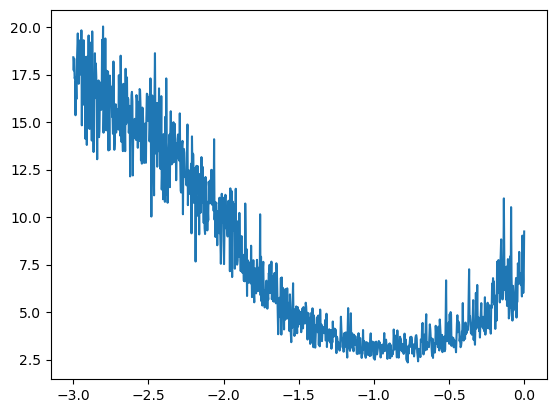

In [125]:
plt.plot(lri, lossi)

Base on the plot, loss is less before exploding is exponent of -1.0 which is 0.1 which was our initial learning rate.
Now we can be certain that the learning rate is good.
Let's set lr to 0.1 and train for a longer period.

In [127]:
# Parameters
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f"Total parametrs: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Total parametrs: 3481


In [131]:
# Good learning rate from metrics
for i in range(10000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = 0.1
    for p in parameters:
        p.data += - lr * p.grad


print(f"Final loss: {loss.item()}")

Final loss: 2.0804283618927


In [132]:
# Evaluation loss for entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3025, grad_fn=<NllLossBackward0>)

After running traing for more than 10000 steps multiple times, we've overcome the loss of bigram model.
Now we've arrived at a point where we are near the minima. Let's do a decay of learning rate to slowly reach there.

And train.

In [133]:
# Learning rate Decay
for i in range(10000):

    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Set gradient to None
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update weights
    lr = 0.01
    for p in parameters:
        p.data += - lr * p.grad


print(f"Final loss: {loss.item()}")

Final loss: 2.0946085453033447


### Summary

* Find a good leaarning rate between lower and upper limit
* Train on the ideal learning rate and check for improvement in loss
* Verify that and do a learning rate decay by a small factor and train again
* Validate loss again on entitre dataset